In [1]:
cd /Users/liangqiaohao/Downloads/PV Lab/2020/March/Learning project/C2a

/Users/liangqiaohao/Downloads/PV Lab/2020/March/Learning project/C2a


In [2]:
import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import GPyOpt

import os

import matplotlib as mpl
import matplotlib.tri as tri

import ternary
import pickle
import datetime

from collections import Counter
import matplotlib.ticker as ticker


In [4]:
dataset = pd.read_excel(r'/Users/liangqiaohao/Downloads/PV Lab/2020/March/Learning project/C2a/C2a learning study.xlsx')
X = dataset.iloc[:,0:5]

X_run = X

materials = ['CsPbI', 'MAPbI', 'FAPbI']
X_feature = X_run[['CsPbI', 'MAPbI', 'FAPbI']]
X_Cs = np.array(X_run['CsPbI'].values)
X_FA = np.array(X_run['FAPbI'].values)
X_MA = np.array(X_run['MAPbI'].values)
X_instability = np.array(X_run['Instability index'].values)

# if ever use for round study
# X_r0 = X_run[X['Round'] == 0]
# X_r1 = X_run[X['Round'] == 1]
# X_r2 = X_run[X['Round'] == 2]
# X_r3 = X_run[X['Round'] == 3]


In [5]:
X_run

,Round,CsPbI,FAPbI,MAPbI,Instability index
0,0,0.00,1.00,0.00,480185
1,0,0.00,1.00,0.00,505657
2,0,0.25,0.75,0.00,144074
3,0,0.50,0.50,0.00,239852
4,0,0.50,0.50,0.00,416657
...,...,...,...,...,...
134,4,0.26,0.38,0.36,593083
135,4,0.00,0.00,1.00,1375402
136,4,0.00,0.00,1.00,1413800
137,4,0.00,0.00,1.00,1583406


In [72]:
def plot_tri(X_Cs, X_MA, X_FA, X_instability, name, scatter):
    colormap = 'RdBu_r'
    
    a = X_FA
    b = X_Cs
    c = X_MA

    x = 0.5 * ( 2.*b+c ) / ( a+b+c )
    y = 0.5*np.sqrt(3) * c / (a+b+c)

    T = tri.Triangulation(x,y)

    mpl.rcParams.update({'font.size': 22})
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_figheight(5)
    fig.set_figwidth(7)

    lims = [np.min(X_instability), np.max(X_instability)]
    norm = matplotlib.colors.Normalize(vmin=lims[0], vmax=lims[1])
    im=ax.tricontourf(x,y,T.triangles,X_instability)
    im.set_norm(norm)
    
#     ax.scatter(x, y)

    corners = np.array([[0, 0], [1, 0], [0.5,  np.sqrt(3)*0.5]])
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=3)

    im2 = ax.triplot(trimesh,'k--')
    
    if scatter == True:
        im3 = ax.scatter(x, y, s=20, c=np.ravel(X_instability), cmap=colormap, 
                         alpha=1, zorder=2, norm=norm)

    myformatter=matplotlib.ticker.ScalarFormatter()
    myformatter.set_powerlimits((1,2))
    cbar=plt.colorbar(im, ax=ax, format=myformatter)
    cbar.set_label('Instability Index (a.u.)', fontsize=14)
    plt.axis('off')
    plt.text(0.35,-0.08,'CsPbI (%)', fontsize=14)
    plt.text(0.1,0.33,'FAPbI (%)', rotation=62, fontsize=14)
    plt.text(0.77,0.29,'MAPbI (%)', rotation=-62, fontsize=14)
    # plt.text(0.35,0.95,'Round '+str(i))
    plt.text(-0.01, -0.06, '0', fontsize=14)#-0.02, -0.06
    plt.text(0.90, -0.06, '1', fontsize=14)#093 -006
    plt.text(-0.06, 0.02, '1', fontsize=14, rotation=62)
    plt.text(0.41, 0.85, '0', fontsize=14, rotation=62)
    plt.text(0.98, 0.02, '0', fontsize=14, rotation=-62)
    plt.text(0.51, 0.85, '1', fontsize=14, rotation=-62)

    plt.show()
    
    print('This is the '+name)
    
def plot_learning(y_dictionary, max_min):
    
    fig = plt.figure(figsize=(15,10))
    ax0 = fig.add_subplot(111)
    
    keys_OptMethods = list(y_dictionary.keys())
    
    markers = [".", ">", "s", "*", "P","x", "d", "^"]
    
    m = 0
    
    for key in keys_OptMethods:
        y = y_dictionary[key]
        n = len(y)
        y_ = []
    
        if max_min == 1:
    #         optimization is maximization
            y_max = -10**10
            for i in np.arange(n):
                if y[i] >= y_max:
                    y_max = y[i]
                y_.append(y_max)   
        elif max_min == -1:
    #         optimization is min
            y_min = 10**10
            for i in np.arange(n):
                if y[i] <= y_min:
                    y_min = y[i]
                y_.append(y_min)
                
        
    
        ax0.plot(np.arange(n), y_, label = key)
        ax0.scatter(np.arange(n), y_, marker = markers[m], s = 9)
        
        m +=1
    
    
    
    format_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/10**4))
    ax0.yaxis.set_major_formatter(format_y)
    ax0.set_title('Best by Nsample')
    ax0.legend(title="Optimization method",
               loc="upper right")
    ax0.set_ylim(ymin = 0)
    ax0.set_ylabel('Instability Index')
        
        
    
def plot_BOprocess(X_instability, rounds, name):
    assert len(X_instability) == len(rounds)
    
    unique_rounds = Counter(rounds).keys()
    n_rounds = len(unique_rounds)
    d = {'index': np.arange(len(X_instability)), 'round': rounds, 'Instability': np.array(X_instability)}
    df = pd.DataFrame(data = d)
    
    min_per_round = []
  
    def get_cmap(n, name='hsv'):
        return plt.cm.get_cmap(name, n)
    
    fig = plt.figure(figsize=(15,21))
    ax0 = fig.add_subplot(311)
    ax1 = fig.add_subplot(312)
    ax2 = fig.add_subplot(313)

    format_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/10**4))
    
    cmap = get_cmap(n_rounds)
    for i in np.arange(n_rounds):
        df_round_i = df[df['round'] == i]
        x = np.array(df_round_i['index'].values)
        y = np.array(df_round_i['Instability'].values)
        min_per_round.append(np.min(y))
        ax0.scatter(x, y, color = cmap(i))
    
    ax0.set_title('Metric_by_index')
    ax0.yaxis.set_major_formatter(format_y)
    
    sns.boxplot(x='round', y='Instability', data=df, dodge=True, ax=ax1)
    sns.swarmplot(x='round', y='Instability', data=df, palette="Set2",dodge=True, s=8, ax=ax1)
    ax1.set_title('Box_by_round')
    ax1.yaxis.set_major_formatter(format_y)

    assert len(min_per_round) == len(unique_rounds)
    ax2.plot(np.arange(n_rounds), min_per_round)
    ax2.set_title('Best Metric_by_round')
    ax2.yaxis.set_major_formatter(format_y)


In [73]:
bounds = [None for j in range(len(materials))]
for j in range(len(materials)):
    bounds[j] = {'name': materials[j], 'type': 'continuous', 'domain': (0,1)}

tolerance_factor_constraint = '((167*x[:,0]+217*x[:,1]+253*x[:,2])+220)/(1.4142*(119+220))'
constraints_baseline = [{'name': 'constr_A_max', 'constraint': 'x[:,0] +x[:,1] +x[:,2]- ' + str(1)},
                        {'name': 'constr_A_min', 'constraint': str(0.99)+'-x[:,0] -x[:,1]-x[:,2]'},
                        {'name': 'G_tolerance_min', 'constraint': '0.80 - ' + tolerance_factor_constraint},
                        {'name': 'G_tolerance_max', 'constraint': tolerance_factor_constraint + ' - 1'}
                       ]

jitter = 0.01

# aaa = GPyOpt.util.general.normalize(np.array([[i] for i in X_instability]), normalization_type='maxmin')

BO_teacher = GPyOpt.methods.BayesianOptimization(f=None,  
                                                 domain = bounds,
                                                 constraints = constraints_baseline,
                                                 acquisition_type = 'EI',              
                                                 normalize_Y = True,
                                                 X = np.array(X_feature) ,
                                                 Y = np.array([[i] for i in X_instability]),
                                                 evaluator_type = 'local_penalization',
                                                 batch_size = 1,
                                                 acquisition_jitter = jitter)

# we don't care yet, this line here is to just fit the GP
_ = BO_teacher.suggest_next_locations()

# Generate grid with 1% resolution
grid_linspace = np.linspace(0, 1, 101)
grid_array = np.array([999, 999, 999])

for i in grid_linspace:
    for j in grid_linspace:
        for k in grid_linspace:
            x = np.array([i, j, k])
            if i + j + k == 1:
                grid_array = np.vstack((grid_array, x))
grid_array = grid_array[1:]

# denormalazing
input_mean = np.mean(X_instability)
input_std = np.std(X_instability)

# grid_pred_mean = BO_teacher.model.predict(grid_array)[0][:,0] * input_std + input_mean
# grid_pred_mean_std = BO_teacher.model.predict(grid_array)[1][:,0]* input_std

# plot_tri(grid_array[:,0],grid_array[:,1],grid_array[:,2], grid_pred_mean, 'GP model', False)
# plot_tri(X_Cs, X_MA, X_FA, X_instability, 'raw experimental', True)


In [97]:
GP_ground_instability = BO_teacher.model.predict(grid_array)[0][:,0] * input_std + input_mean
best_index = np.where(GP_ground_instability == np.sort(GP_ground_instability)[0])
grid_array[best_index]

array([[0.16, 0.05, 0.79]])

In [90]:
GP_ground_instability = BO_teacher.model.predict(np.array(X_feature))[0][:,0] * input_std + input_mean
X_GP_ground = X_run.copy()
X_GP_ground['Instability index'] = GP_ground_instability
X_GP_ground

,Round,CsPbI,FAPbI,MAPbI,Instability index
0,0,0.00,1.00,0.00,4.707059e+05
1,0,0.00,1.00,0.00,4.707059e+05
2,0,0.25,0.75,0.00,1.741913e+05
3,0,0.50,0.50,0.00,2.870505e+05
4,0,0.50,0.50,0.00,2.870505e+05
...,...,...,...,...,...
134,4,0.26,0.38,0.36,4.993700e+05
135,4,0.00,0.00,1.00,1.448000e+06
136,4,0.00,0.00,1.00,1.448000e+06
137,4,0.00,0.00,1.00,1.448000e+06


In [93]:
X_GP_ground.sort_values(['Instability index']).head(25)

,Round,CsPbI,FAPbI,MAPbI,Instability index
118,4,0.17,0.80,0.03,108162.041897
117,4,0.17,0.80,0.03,108162.041897
119,4,0.17,0.80,0.03,108162.041897
116,4,0.17,0.80,0.03,108162.041897
66,2,0.16,0.83,0.01,110091.920676
67,2,0.17,0.82,0.01,111015.177581
98,3,0.18,0.78,0.04,111567.040002
29,1,0.16,0.84,0.00,111661.232444
28,1,0.16,0.84,0.00,111661.232444
71,2,0.14,0.84,0.02,114107.587170


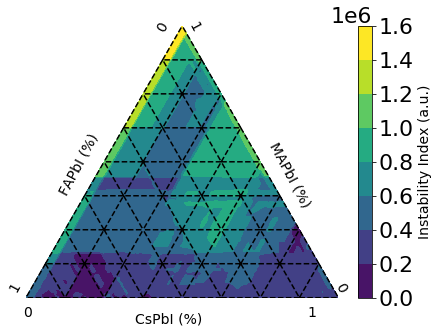

This is the XGboost model


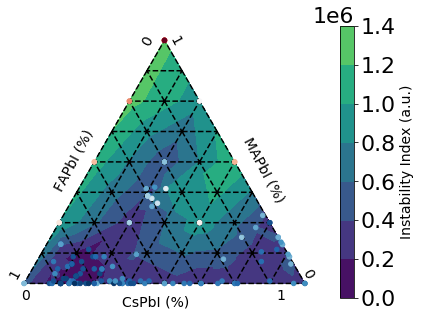

This is the raw experimental


In [94]:
import xgboost as xgb
# https://xgboost.readthedocs.io/en/latest/parameter.html
num_round = 3000
dtrain = xgb.DMatrix(np.array(X_feature), label=X_instability)

# tt = []
# for depth_ in [2,3,4,5,6,7,8,9,10]:
#     for eta_ in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
#         param = {'max_depth': depth_, 'eta': eta_, 'objective': 'reg:squarederror'}
#         bst = xgb.train(param, dtrain, num_round)
#         pred = bst.predict(xgb.DMatrix(X_feature.to_numpy()))
#         mae = np.sum((pred - X_instability)**2) / len(X_instability)
#         tt.append([depth_, eta_, mae])

# opt_XGboost = pd.DataFrame(tt, columns=['depth_', 'eta_', 'mae'])

param = {'max_depth': 6, 'eta': 0.3, 'objective': 'reg:squarederror'}
bst = xgb.train(param, dtrain, num_round)
plot_tri(grid_array[:,0],grid_array[:,1],grid_array[:,2], bst.predict(xgb.DMatrix(grid_array)), 'XGboost model', False)
plot_tri(X_Cs, X_MA, X_FA, X_instability, 'raw experimental', True)

# Note
# 1.
# pred = bst.predict(xgb.DMatrix(X_feature.to_numpy()))
# mae = np.sum((pred - X_instability)**2) / len(X_instability)
# <
# pred = BO_teacher.model.predict(X_feature.to_numpy())[0][:,0] * input_std + input_mean
# mae = np.sum((pred - X_instability)**2) / len(X_instability)
# 2.
# XGboost input not normalized. not necessary

In [98]:
XGB_ground_instability = bst.predict(xgb.DMatrix(grid_array))
best_index = np.where(XGB_ground_instability == np.sort(XGB_ground_instability)[0])
grid_array[best_index]

array([[0.18, 0.  , 0.82]])

In [95]:
XGB_ground_instability = bst.predict(xgb.DMatrix(np.array(X_feature)))
X_XGB_ground = X_run.copy()
X_XGB_ground['Instability index'] = XGB_ground_instability
X_XGB_ground

,Round,CsPbI,FAPbI,MAPbI,Instability index
0,0,0.00,1.00,0.00,4.929209e+05
1,0,0.00,1.00,0.00,4.929209e+05
2,0,0.25,0.75,0.00,1.636269e+05
3,0,0.50,0.50,0.00,3.282544e+05
4,0,0.50,0.50,0.00,3.282544e+05
...,...,...,...,...,...
134,4,0.26,0.38,0.36,5.462396e+05
135,4,0.00,0.00,1.00,1.452513e+06
136,4,0.00,0.00,1.00,1.452513e+06
137,4,0.00,0.00,1.00,1.452513e+06


In [96]:
X_XGB_ground.sort_values(['Instability index']).head(25)

,Round,CsPbI,FAPbI,MAPbI,Instability index
85,3,0.18,0.82,0.00,27122.339844
60,2,0.23,0.77,0.00,38893.355469
62,2,0.32,0.68,0.00,40621.289062
84,3,0.13,0.87,0.00,57298.617188
115,4,0.13,0.87,0.00,57298.617188
113,4,0.13,0.87,0.00,57298.617188
114,4,0.13,0.87,0.00,57298.617188
112,4,0.13,0.87,0.00,57298.617188
118,4,0.17,0.80,0.03,72999.804688
119,4,0.17,0.80,0.03,72999.804688


In [52]:
# batch and rounds for BO
batch = 1
rounds = 75
n_eval = batch * rounds
jitter = 0.01

seed_list = [74,660,861,1526,2,151,19,7,33,4021,66,42424,671,25,95711,850,71,2148,26219,4]
# 20

In [53]:
import pyDOE
import random

X_BO_initRS_EI_collection = []
run_BO_initRS_EI_collection = []
Instability_BO_initRS_EI_collection = []

for s in seed_list:
    
    # initial_sampling = constrained random sampling = cRS
    # optimization = GpyOpt

    random.seed(s)
    design_space = GPyOpt.core.task.space.Design_space(space = bounds, 
                                                       constraints=constraints_baseline)
    sampler = GPyOpt.experiment_design.random_design.RandomDesign(design_space)

    X_BO_initRS_EI = []
    run_BO_initRS_EI = []
    Instability_BO_initRS_EI = []

    for i in np.arange(rounds):
        if i == 0:
            initial_X = sampler.get_samples(batch)
            initial_Instability = BO_teacher.model.predict(initial_X)[0][:,0] * input_std + input_mean
            for j in np.arange(batch):
                X_BO_initRS_EI.append(initial_X[j])
                run_BO_initRS_EI.append(i)
                Instability_BO_initRS_EI.append(initial_Instability[j])

            min_round = np.min(initial_Instability)
            min_index = np.where(initial_Instability == min_round)

#             print('round '+str(i)+' finished, best found at ' +str(initial_X[min_index]) + ' is '+str(min_round))
        else:
            BO_model = GPyOpt.methods.BayesianOptimization(f=None,  
                                            domain = bounds,
                                            constraints = constraints_baseline,
                                            acquisition_type = 'EI',              
                                            normalize_Y = True,
                                            X = np.array(X_BO_initRS_EI),
                                            Y = np.array([[i] for i in Instability_BO_initRS_EI]),
                                            evaluator_type = 'local_penalization',
                                            batch_size = batch,
                                            acquisition_jitter = jitter)

            suggested_next_X = BO_model.suggest_next_locations()

            assert len(suggested_next_X) == batch

            suggested_next_Instability = BO_teacher.model.predict(suggested_next_X)[0][:,0] * input_std + input_mean
            
            
            for j in np.arange(batch):
                X_BO_initRS_EI.append(suggested_next_X[j])
                run_BO_initRS_EI.append(i)
                Instability_BO_initRS_EI.append(suggested_next_Instability[j])

#             min_round = np.min(suggested_next_Instability)
#             min_index = np.where(suggested_next_Instability == min_round)
#             print('round '+str(i)+' finished, best found at ' +str(suggested_next_X[min_index]) + ' is '+str(min_round))
    X_BO_initRS_EI_collection.append(X_BO_initRS_EI)
    run_BO_initRS_EI_collection.append(run_BO_initRS_EI)
    Instability_BO_initRS_EI_collection.append(Instability_BO_initRS_EI)
    print('Finished e')
    
master = np.array([X_BO_initRS_EI_collection, run_BO_initRS_EI_collection, Instability_BO_initRS_EI_collection])
np.save('GP_BO_EI_master', master)


Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e


In [54]:
# random sampling

X_RS_collection = []
Instability_RS_collection = []

for s in seed_list:

    random.seed(s)
    design_space = GPyOpt.core.task.space.Design_space(space = bounds, 
                                                       constraints=constraints_baseline)
    sampler = GPyOpt.experiment_design.random_design.RandomDesign(design_space)

    X_rs = sampler.get_samples(n_eval)
    Instability_RS = BO_teacher.model.predict(X_rs)[0][:,0] * input_std + input_mean
    
    

    # plot_tri(X_rs[:,0], X_rs[:,1], X_rs[:,2], Instability_RS, 'random sampling', True)
    X_RS_collection.append(X_rs)
    Instability_RS_collection.append(Instability_RS)
    print('Finished e')
    
master = np.array([X_RS_collection, 0, Instability_RS_collection])
np.save('GP_RS_master', master)

Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e


In [55]:
X_BO_initRS_MPI_collection = []
run_BO_initRS_MPI_collection = []
Instability_BO_initRS_MPI_collection = []

for s in seed_list:
    random.seed(s)

    design_space = GPyOpt.core.task.space.Design_space(space = bounds, 
                                                       constraints=constraints_baseline)
    sampler = GPyOpt.experiment_design.random_design.RandomDesign(design_space)

    X_BO_initRS_MPI = []
    run_BO_initRS_MPI = []
    Instability_BO_initRS_MPI = []

    for i in np.arange(rounds):
        if i == 0:
            initial_X = sampler.get_samples(batch)
            initial_Instability = BO_teacher.model.predict(initial_X)[0][:,0] * input_std + input_mean
            for j in np.arange(batch):
                X_BO_initRS_MPI.append(initial_X[j])
                run_BO_initRS_MPI.append(i)
                Instability_BO_initRS_MPI.append(initial_Instability[j])

            min_round = np.min(initial_Instability)
            min_index = np.where(initial_Instability == min_round)

#             print('round '+str(i)+' finished, best found at ' +str(initial_X[min_index]) + ' is '+str(min_round))
        else:
            BO_model = GPyOpt.methods.BayesianOptimization(f=None,  
                                            domain = bounds,
                                            constraints = constraints_baseline,
                                            acquisition_type = 'MPI',              
                                            normalize_Y = True,
                                            X = np.array(X_BO_initRS_MPI),
                                            Y = np.array([[i] for i in Instability_BO_initRS_MPI]),
                                            evaluator_type = 'local_penalization',
                                            batch_size = batch,
                                            acquisition_jitter = jitter)

            suggested_next_X = BO_model.suggest_next_locations()

            assert len(suggested_next_X) == batch

            suggested_next_Instability = BO_teacher.model.predict(suggested_next_X)[0][:,0] * input_std + input_mean
            
            
            for j in np.arange(batch):
                X_BO_initRS_MPI.append(suggested_next_X[j])
                run_BO_initRS_MPI.append(i)
                Instability_BO_initRS_MPI.append(suggested_next_Instability[j])

            min_round = np.min(suggested_next_Instability)
            min_index = np.where(suggested_next_Instability == min_round)

#             print('round '+str(i)+' finished, best found at ' +str(suggested_next_X[min_index]) + ' is '+str(min_round))

    # plot_tri(np.array(X_BO_initRS_EI)[:,0], np.array(X_BO_initRS_EI)[:,1], np.array(X_BO_initRS_EI)[:,2], Instability_BO_initRS_EI, 'BO_EI', True)    
    # plot_BOprocess(Instability_BO_initRS_EI, run_BO_initRS_EI, 'BO_EI')
    X_BO_initRS_MPI_collection.append(X_BO_initRS_MPI)
    run_BO_initRS_MPI_collection.append(run_BO_initRS_MPI)
    Instability_BO_initRS_MPI_collection.append(Instability_BO_initRS_MPI)
    print('Finished e')
    
master = np.array([X_BO_initRS_MPI_collection, run_BO_initRS_MPI_collection, Instability_BO_initRS_MPI_collection])
np.save('GP_BO_MPI_master', master)

Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e


In [56]:
X_BO_initRS_LCB_collection = []
run_BO_initRS_LCB_collection = []
Instability_BO_initRS_LCB_collection = []

for s in seed_list:
    random.seed(s)
    
    design_space = GPyOpt.core.task.space.Design_space(space = bounds, 
                                                       constraints=constraints_baseline)
    sampler = GPyOpt.experiment_design.random_design.RandomDesign(design_space)

    X_BO_initRS_LCB = []
    run_BO_initRS_LCB = []
    Instability_BO_initRS_LCB = []

    for i in np.arange(rounds):
        if i == 0:
            initial_X = sampler.get_samples(batch)
            initial_Instability = BO_teacher.model.predict(initial_X)[0][:,0] * input_std + input_mean
            for j in np.arange(batch):
                X_BO_initRS_LCB.append(initial_X[j])
                run_BO_initRS_LCB.append(i)
                Instability_BO_initRS_LCB.append(initial_Instability[j])

            min_round = np.min(initial_Instability)
            min_index = np.where(initial_Instability == min_round)

#             print('round '+str(i)+' finished, best found at ' +str(initial_X[min_index]) + ' is '+str(min_round))
        else:
            BO_model = GPyOpt.methods.BayesianOptimization(f=None,  
                                            domain = bounds,
                                            constraints = constraints_baseline,
                                            acquisition_type = 'LCB',              
                                            normalize_Y = True,
                                            X = np.array(X_BO_initRS_LCB),
                                            Y = np.array([[i] for i in Instability_BO_initRS_LCB]),
                                            evaluator_type = 'local_penalization',
                                            batch_size = batch,
                                            acquisition_jitter = jitter)

            suggested_next_X = BO_model.suggest_next_locations()

            assert len(suggested_next_X) == batch

            suggested_next_Instability = BO_teacher.model.predict(suggested_next_X)[0][:,0] * input_std + input_mean
            
            
            for j in np.arange(batch):
                X_BO_initRS_LCB.append(suggested_next_X[j])
                run_BO_initRS_LCB.append(i)
                Instability_BO_initRS_LCB.append(suggested_next_Instability[j])

            min_round = np.min(suggested_next_Instability)
            min_index = np.where(suggested_next_Instability == min_round)

#             print('round '+str(i)+' finished, best found at ' +str(suggested_next_X[min_index]) + ' is '+str(min_round))

    # plot_tri(np.array(X_BO_initRS_EI)[:,0], np.array(X_BO_initRS_EI)[:,1], np.array(X_BO_initRS_EI)[:,2], Instability_BO_initRS_EI, 'BO_EI', True)    
    # plot_BOprocess(Instability_BO_initRS_EI, run_BO_initRS_EI, 'BO_EI')
    X_BO_initRS_LCB_collection.append(X_BO_initRS_LCB)
    run_BO_initRS_LCB_collection.append(run_BO_initRS_LCB)
    Instability_BO_initRS_LCB_collection.append(Instability_BO_initRS_LCB)
    print('Finished e')
    
master = np.array([X_BO_initRS_LCB_collection, run_BO_initRS_LCB_collection, Instability_BO_initRS_LCB_collection])
np.save('GP_BO_LCB_master', master)

The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ign

In [57]:
# # grid search + random sampling
# from random import sample

# grid_linspace = np.linspace(0, 1, 50)
# grid_array = np.array([999, 999, 999])

# for i in grid_linspace:
#     for j in grid_linspace:
#         for k in grid_linspace:
#             x = np.array([i, j, k])
#             if i + j + k == 1:
#                 grid_array = np.vstack((grid_array, x))
# grid_array = grid_array[1:]

# # grid_pred_mean = BO_teacher.model.predict(grid_array)[0][:,0] * input_std + input_mean
# # grid_pred_mean_std = BO_teacher.model.predict(grid_array)[1][:,0]* input_std

# grid_pred = bst.predict(xgb.DMatrix(grid_array))

# X_grid_collection = []
# Instability_grid_collection = []

# for s in seed_list:
#     random.seed(s)
#     list_index = sample(list(np.arange(len(grid_pred_mean))),n_eval)
#     X_grid = []
#     Instability_grid = []
#     for i in list_index:
#         X_grid.append(grid_array[i])
#         Instability_grid.append(grid_pred_mean[i])
#     X_grid_collection.append(X_grid)
#     Instability_grid_collection.append(Instability_grid)
#     print('Finished e')
    
# master = np.array([X_grid_collection, 0, Instability_grid_collection])
# np.save('Grid_master', master)


In [58]:
X_BO_initRS_EI_collection = []
run_BO_initRS_EI_collection = []
Instability_BO_initRS_EI_collection = []

for s in seed_list:
    
    # initial_sampling = constrained random sampling = cRS
    # optimization = GpyOpt

    random.seed(s)
    design_space = GPyOpt.core.task.space.Design_space(space = bounds, 
                                                       constraints=constraints_baseline)
    sampler = GPyOpt.experiment_design.random_design.RandomDesign(design_space)

    X_BO_initRS_EI = []
    run_BO_initRS_EI = []
    Instability_BO_initRS_EI = []

    for i in np.arange(rounds):
        if i == 0:
            initial_X = sampler.get_samples(batch)
            initial_Instability = BO_teacher.model.predict(initial_X)[0][:,0] * input_std + input_mean
            for j in np.arange(batch):
                X_BO_initRS_EI.append(initial_X[j])
                run_BO_initRS_EI.append(i)
                Instability_BO_initRS_EI.append(initial_Instability[j])

            min_round = np.min(initial_Instability)
            min_index = np.where(initial_Instability == min_round)

#             print('round '+str(i)+' finished, best found at ' +str(initial_X[min_index]) + ' is '+str(min_round))
        else:
            BO_model = GPyOpt.methods.BayesianOptimization(f=None,  
                                            domain = bounds,
                                            constraints = constraints_baseline,
                                            acquisition_type = 'EI',              
                                            normalize_Y = True,
                                            X = np.array(X_BO_initRS_EI),
                                            Y = np.array([[i] for i in Instability_BO_initRS_EI]),
                                            evaluator_type = 'local_penalization',
                                            batch_size = batch,
                                            acquisition_jitter = jitter)

            suggested_next_X = BO_model.suggest_next_locations()

            assert len(suggested_next_X) == batch

            suggested_next_Instability = bst.predict(xgb.DMatrix(suggested_next_X))
            
            for j in np.arange(batch):
                X_BO_initRS_EI.append(suggested_next_X[j])
                run_BO_initRS_EI.append(i)
                Instability_BO_initRS_EI.append(suggested_next_Instability[j])

#             min_round = np.min(suggested_next_Instability)
#             min_index = np.where(suggested_next_Instability == min_round)
#             print('round '+str(i)+' finished, best found at ' +str(suggested_next_X[min_index]) + ' is '+str(min_round))
    X_BO_initRS_EI_collection.append(X_BO_initRS_EI)
    run_BO_initRS_EI_collection.append(run_BO_initRS_EI)
    Instability_BO_initRS_EI_collection.append(Instability_BO_initRS_EI)
    print('Finished e')
    
master = np.array([X_BO_initRS_EI_collection, run_BO_initRS_EI_collection, Instability_BO_initRS_EI_collection])
np.save('XGB_BO_EI_master', master)

Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e


In [59]:
X_RS_collection = []
Instability_RS_collection = []

for s in seed_list:

    random.seed(s)
    design_space = GPyOpt.core.task.space.Design_space(space = bounds, 
                                                       constraints=constraints_baseline)
    sampler = GPyOpt.experiment_design.random_design.RandomDesign(design_space)

    X_rs = sampler.get_samples(n_eval)

    Instability_RS = bst.predict(xgb.DMatrix(X_rs))
    

    # plot_tri(X_rs[:,0], X_rs[:,1], X_rs[:,2], Instability_RS, 'random sampling', True)
    X_RS_collection.append(X_rs)
    Instability_RS_collection.append(Instability_RS)
    print('Finished e')
    
master = np.array([X_RS_collection, 0, Instability_RS_collection])
np.save('XGB_RS_master', master)

Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e


In [60]:
X_BO_initRS_MPI_collection = []
run_BO_initRS_MPI_collection = []
Instability_BO_initRS_MPI_collection = []

for s in seed_list:
    random.seed(s)

    design_space = GPyOpt.core.task.space.Design_space(space = bounds, 
                                                       constraints=constraints_baseline)
    sampler = GPyOpt.experiment_design.random_design.RandomDesign(design_space)

    X_BO_initRS_MPI = []
    run_BO_initRS_MPI = []
    Instability_BO_initRS_MPI = []

    for i in np.arange(rounds):
        if i == 0:
            initial_X = sampler.get_samples(batch)
            initial_Instability = BO_teacher.model.predict(initial_X)[0][:,0] * input_std + input_mean
            for j in np.arange(batch):
                X_BO_initRS_MPI.append(initial_X[j])
                run_BO_initRS_MPI.append(i)
                Instability_BO_initRS_MPI.append(initial_Instability[j])

            min_round = np.min(initial_Instability)
            min_index = np.where(initial_Instability == min_round)

#             print('round '+str(i)+' finished, best found at ' +str(initial_X[min_index]) + ' is '+str(min_round))
        else:
            BO_model = GPyOpt.methods.BayesianOptimization(f=None,  
                                            domain = bounds,
                                            constraints = constraints_baseline,
                                            acquisition_type = 'MPI',              
                                            normalize_Y = True,
                                            X = np.array(X_BO_initRS_MPI),
                                            Y = np.array([[i] for i in Instability_BO_initRS_MPI]),
                                            evaluator_type = 'local_penalization',
                                            batch_size = batch,
                                            acquisition_jitter = jitter)

            suggested_next_X = BO_model.suggest_next_locations()

            assert len(suggested_next_X) == batch


            suggested_next_Instability = bst.predict(xgb.DMatrix(suggested_next_X))
            
            for j in np.arange(batch):
                X_BO_initRS_MPI.append(suggested_next_X[j])
                run_BO_initRS_MPI.append(i)
                Instability_BO_initRS_MPI.append(suggested_next_Instability[j])

            min_round = np.min(suggested_next_Instability)
            min_index = np.where(suggested_next_Instability == min_round)

#             print('round '+str(i)+' finished, best found at ' +str(suggested_next_X[min_index]) + ' is '+str(min_round))

    # plot_tri(np.array(X_BO_initRS_EI)[:,0], np.array(X_BO_initRS_EI)[:,1], np.array(X_BO_initRS_EI)[:,2], Instability_BO_initRS_EI, 'BO_EI', True)    
    # plot_BOprocess(Instability_BO_initRS_EI, run_BO_initRS_EI, 'BO_EI')
    X_BO_initRS_MPI_collection.append(X_BO_initRS_MPI)
    run_BO_initRS_MPI_collection.append(run_BO_initRS_MPI)
    Instability_BO_initRS_MPI_collection.append(Instability_BO_initRS_MPI)
    print('Finished e')
    
master = np.array([X_BO_initRS_MPI_collection, run_BO_initRS_MPI_collection, Instability_BO_initRS_MPI_collection])
np.save('XGB_BO_MPI_master', master)

Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e
Finished e


In [61]:
X_BO_initRS_LCB_collection = []
run_BO_initRS_LCB_collection = []
Instability_BO_initRS_LCB_collection = []

for s in seed_list:
    random.seed(s)
    
    design_space = GPyOpt.core.task.space.Design_space(space = bounds, 
                                                       constraints=constraints_baseline)
    sampler = GPyOpt.experiment_design.random_design.RandomDesign(design_space)

    X_BO_initRS_LCB = []
    run_BO_initRS_LCB = []
    Instability_BO_initRS_LCB = []

    for i in np.arange(rounds):
        if i == 0:
            initial_X = sampler.get_samples(batch)
            initial_Instability = BO_teacher.model.predict(initial_X)[0][:,0] * input_std + input_mean
            for j in np.arange(batch):
                X_BO_initRS_LCB.append(initial_X[j])
                run_BO_initRS_LCB.append(i)
                Instability_BO_initRS_LCB.append(initial_Instability[j])

            min_round = np.min(initial_Instability)
            min_index = np.where(initial_Instability == min_round)

#             print('round '+str(i)+' finished, best found at ' +str(initial_X[min_index]) + ' is '+str(min_round))
        else:
            BO_model = GPyOpt.methods.BayesianOptimization(f=None,  
                                            domain = bounds,
                                            constraints = constraints_baseline,
                                            acquisition_type = 'LCB',              
                                            normalize_Y = True,
                                            X = np.array(X_BO_initRS_LCB),
                                            Y = np.array([[i] for i in Instability_BO_initRS_LCB]),
                                            evaluator_type = 'local_penalization',
                                            batch_size = batch,
                                            acquisition_jitter = jitter)

            suggested_next_X = BO_model.suggest_next_locations()

            assert len(suggested_next_X) == batch


            suggested_next_Instability = bst.predict(xgb.DMatrix(suggested_next_X))
            
            for j in np.arange(batch):
                X_BO_initRS_LCB.append(suggested_next_X[j])
                run_BO_initRS_LCB.append(i)
                Instability_BO_initRS_LCB.append(suggested_next_Instability[j])

            min_round = np.min(suggested_next_Instability)
            min_index = np.where(suggested_next_Instability == min_round)

#             print('round '+str(i)+' finished, best found at ' +str(suggested_next_X[min_index]) + ' is '+str(min_round))

    # plot_tri(np.array(X_BO_initRS_EI)[:,0], np.array(X_BO_initRS_EI)[:,1], np.array(X_BO_initRS_EI)[:,2], Instability_BO_initRS_EI, 'BO_EI', True)    
    # plot_BOprocess(Instability_BO_initRS_EI, run_BO_initRS_EI, 'BO_EI')
    X_BO_initRS_LCB_collection.append(X_BO_initRS_LCB)
    run_BO_initRS_LCB_collection.append(run_BO_initRS_LCB)
    Instability_BO_initRS_LCB_collection.append(Instability_BO_initRS_LCB)
    print('Finished e')
    
master = np.array([X_BO_initRS_LCB_collection, run_BO_initRS_LCB_collection, Instability_BO_initRS_LCB_collection])
np.save('XGB_BO_LCB_master', master)

The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ign